In [ ]:
#Printing the grid
class ZooEnvironmentprint:
    def __init__(self):
        self.grid_size = 6  # 6x6 grid
        self.grid = [[' ' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        #Grid elements
        self.features = {
            (0, 2): 'Monkey', (0, 5): 'Tunnel 2',
            (1, 0): 'Giraffe',
            (2, 4): 'Tunnel 1', (2, 5): 'Lion',
            (3, 0): 'Enter 1', (3, 2): 'Cleaning',
            (4, 2): 'Elephant', (4, 5): 'Exit',
            (5, 4): 'Zebra'
        }

    def setup_grid(self):
        # Place features on the grid
        for position, label in self.features.items():
            x, y = position
            if label.startswith('Enter 1'):
                self.grid[x][y] = 'E1'
            elif label == 'Elephant':
                self.grid[x][y] = 'EL'  # Display "Elephant" as "EL"
            elif label in ['Monkey', 'Lion', 'Zebra', 'Giraffe']:
                self.grid[x][y] = label[0]  # First letter of the other animal names
            elif label.startswith('Tunnel 1'):
                self.grid[x][y] = 'T1'
            elif label.startswith('Tunnel 2'):
                self.grid[x][y] = 'T2'
            elif label == 'Cleaning':
                self.grid[x][y] = 'C'
            elif label == 'Exit':
                self.grid[x][y] = '➡️'

    def print_environment(self):
        print("Zoo Navigation Grid:")
        for row in self.grid:
            print('|' + '|'.join(f"{cell: <3}" for cell in row) + '|')

if __name__ == "__main__":
    zoo = ZooEnvironmentprint()
    zoo.setup_grid()
    zoo.print_environment()


Zoo Navigation Grid:
|   |   |M  |   |   |T2 |
|G  |   |   |   |   |   |
|   |   |   |   |T1 |L  |
|E1 |   |C  |   |   |   |
|   |   |EL |   |   |➡️ |
|   |   |   |   |Z  |   |


In [ ]:
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
import random
import matplotlib.pyplot as plt

#Zoo environment set-up
class ZooEnv():
    def __init__(self,
                 dims=(6, 6),  # grid size
                 rewards={'r_time': -1, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10, 'r_all_animals': 50, 'r_miss_animals': -30},  #Rewars and panelties
                 start=(3, 0),  #Start state
                 end=(4, 5),  #End state
                 positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
                 tunnels= {(0, 5): (2, 4), (2, 4): (0, 5)},
                 epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.99999, 'epsilon_decay2': 0.9999},  #exploration-exploitation points
                 max_steps=100,  #Maximum no. of steps per episode
                 max_episodes=1000,  #No. of training episodes
                 random_seed=42):
      #inintialize the zooenv variables
        self._dims = dims
        self._rewards = rewards
        self._start = start
        self._end = end
        self._tunnels = tunnels
        self._epsilon_decays = epsilon_decays
        self._positions = positions
        self._max_steps = max_steps
        self._max_episodes = max_episodes
        self.current_state = start
        self.visited_animals = set()

        self._initialize_grid()  #Grid initialization
        self._initialize_R_matrix()  #reward matrix initialization
        self._initialize_Q_matrix()  #Q matrix initialization

        self.rng = np.random.default_rng(random_seed)  #Set the random number generator for reproducibility

    #Initialize zooenv grid
    def _initialize_grid(self):
        self._grid = np.zeros(self._dims)
        for position in self._positions:
            for pos in self._positions[position]:
                self._grid[pos[0], pos[1]] = self._rewards['r_' + position]  #assign rewards to cells

        self._grid[self._end[0], self._end[1]] = self._rewards['r_exit_all']  #End state reward
    #printing the zooenv
    def visualise_world(self):
        W = self._dims[1] * 2 + 1
        H = self._dims[0] * 2 + 1
        rows = [['   '] * W for _ in range(H)]

        for i in range(W):
            for j in range(H):
                if i % 2 == 1 and j % 2 == 1:
                    rows[j][i] = '.  '  #normal cells
        #Setting the boundaries
        rows[0] = ['X  ' for _ in rows[0]]
        rows[H - 1] = ['X  ' for _ in rows[H - 1]]
        for i in range(1, H - 1):
            rows[i][0] = 'X  '
            rows[i][W - 1] = 'X  '

        for tunnel in self._tunnels:
            rows[tunnel[0] * 2 + 1][tunnel[1] * 2 + 1] = 'T  '  #Assigning tunnel position

        for label, p in [('S  ', self._start), ('E  ', self._end)]:
            rows[p[0] * 2 + 1][p[1] * 2 + 1] = label  #Assign start and end point

        symbol = {'animal': 'A  ', 'cleaning': 'C  '}
        for key in self._positions:
            for p in self._positions[key]:
                rows[p[0] * 2 + 1][p[1] * 2 + 1] = symbol[key]  #assign animal and cleaning positions

        return self._create_viz_string(rows)

    def _create_viz_string(self, rows):
        s = '\n' + ''.join([''.join(r) + '\n' for r in rows])  #string representation of the grid
        s += '\n'
        s += 'key:\n'
        s += 'S  = start location for agent\n'
        s += 'E  = end location for agent\n'
        s += '.  = empty cell\n'
        s += 'X  = boundary or wall between cells\n'
        s += 'T  = tunnel start or end. Agent can travel between two tunnel points in one time step\n'
        s += 'A  = animal: agent is rewarded for visiting\n'
        s += 'C  = cleaning area: agent is penalized for moving into\n'
        return s

    def _initialize_R_matrix(self):
        d1 = self._dims[0]
        d2 = self._dims[1]
        self._R = np.empty((d1 * d2, d1 * d2))  #Empty reward matrix
        self._R.fill(np.nan)  #No direct transition degined

        self.__fillPossibleActions()
        self.__initializeTunnels()
        self.__initializeAnimals()
        self.__initializeCleaning()
        self.__initializeGoalPoint()

    #Actions def
    def move_to(self, l, feature):
        cell = feature[0] * self._dims[1] + feature[1]

        if feature[0] > 0:
            l.append((cell - self._dims[1], cell))  #up
        if feature[0] < self._dims[0] - 1:
            l.append((cell + self._dims[1], cell))  #down
        if feature[1] > 0:
            l.append((cell - 1, cell))  #left
        if feature[1] < self._dims[1] - 1:
            l.append((cell + 1, cell))  #right

        return l
    #taking actions
    def __fillPossibleActions(self):
        ones = []
        for i in range(self._dims[0]):
            for j in range(self._dims[1]):
                cell = i * self._dims[1] + j
                if j != self._dims[1] - 1:
                    ones.append((cell + 1, cell))  #move right
                if i != self._dims[0] - 1:
                    ones.append((cell + self._dims[1], cell))  #Move down
                if i != 0:
                    ones.append((cell - self._dims[1], cell))  #move up
                if j != 0:
                    ones.append((cell - 1, cell))  #Move left
                ones.append((cell, cell))  #No move

        ones = tuple(zip(*ones))
        self._R[ones] = self._rewards['r_time']  #penalty for each move

    def __initializeGoalPoint(self):
        end_cell = self._end[0] * self._dims[1] + self._end[1]
        ends = self.move_to([], self._end)
        ends.append([end_cell, end_cell])
        ends = tuple(zip(*ends))
        self._R[ends] = self._rewards['r_exit_all']

    def __initializeTunnels(self):
        tunnel_cells = []
        for start, end in self._tunnels.items():
            start_cell = start[0] * self._dims[1] + start[1]
            end_cell = end[0] * self._dims[1] + end[1]
            tunnel_cells.append((start_cell, end_cell))
            tunnel_cells.append((end_cell, start_cell))

        tunnel_cells = tuple(zip(*tunnel_cells))
        self._R[tunnel_cells] = self._rewards['r_tunnel1']  #tunnel reward

    def __initializeAnimals(self):
        animals = []
        for animal in self._positions['animal']:
            animals = self.move_to(animals, animal)

        animals = tuple(zip(*animals))
        self._R[animals] = self._rewards['r_animal']  #visisting animal rewards

    def __initializeCleaning(self):
        cleaning = []
        for clean in self._positions['cleaning']:
            p = clean[0] * self._dims[1] + self._dims[1]
            cleaning = self.move_to(cleaning, clean)
            cleaning.extend([(p, p)])

        cleaning = tuple(zip(*cleaning))
        self._R[cleaning] = self._rewards['r_cleaning']  #cleaning area penalty

    def display_matrix(self, matrix, start=None, end=None):
        pd.set_option("display.max_columns", None)
        print(pd.DataFrame(matrix).loc[start:end, start:end])

    def _initialize_Q_matrix(self):
        self._Q = np.zeros(self._R.shape)  #matrix initialization

    @abstractmethod
    def run_episode(self, Q, alpha, gamma, epsilon):
        pass

    @abstractmethod
    def learn(self, alpha, gamma, epsilon):
        pass

    def _get_adjacent_cells(self, cell):
        cells = np.where(~np.isnan(self._R[cell]))[0]
        return cells

    def _get_actions(self, R, Q, s):
        available = np.where(~np.isnan(R[s]))[0]
        q_vals = [Q[s, a] for a in available]
        best = available[np.where(q_vals == np.max(q_vals))[0]]  #best action based on Q values
        available = available.tolist()
        best = best.tolist()
        return available, best

    def _get_greedy_action(self, epsilon, available, best):
        if self.rng.uniform() > epsilon:
            a = self.rng.choice(best)
        else:
            a = self.rng.choice(available)
        return a

In [ ]:
class Q_Learning(ZooEnv):
    def __init__(self,
                 dims=(6, 6),
                 rewards={'r_time': -1, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},  #Initial Reward structure
                 start=(3, 0),
                 end=(4, 5),
                 positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
                 tunnels={(0, 5): (2, 4), (2, 4): (0, 5)},
                 epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.99999, 'epsilon_decay2': 0.9999},  #epsilon-greedy policy
                 max_steps=100,
                 max_episodes=1000,
                 random_seed=42
                 ):
        super().__init__(dims,
                         rewards,
                         start,
                         end,
                         positions,
                         tunnels,
                         epsilon_decays,
                         max_steps,
                         max_episodes,
                         random_seed
                         )

    def run_episode(self, Q, alpha, gamma, epsilon):
        """
        Run a single episode of Q-learning with parameters Q, alpha, gamma and epsilon
        and returns updated Q-value table, total reward, action history, and number of animals visited as tuple

        """
        R_tot = 0  #initialize total reward
        s = self._start[0] * self._dims[1] + self._start[1]  #convert position to a state value
        action_hist = [s]  #actions tracker list
        goal_state = self._end[0] * self._dims[1] + self._end[1]  #convert goal position to a state value
        R = self._R.copy()  #update R-matrix

        animals_visited = set()  #visited animal positions tracker
        animal_cells = [animal[0] * self._dims[1] + animal[1] for animal in self._positions['animal']]

        for _ in range(self._max_steps):
            available, best = self._get_actions(R, Q, s)
            a = self._get_greedy_action(epsilon, available, best)
            action_hist.append(a)
            s_old = s  #Store current state
            s = a  #Move to new state

            #Update Q-value based on the Bellman equation
            Q[s_old, a] = Q[s_old, a] + alpha * (R[s_old, a] + gamma * Q[s, :].max() - Q[s_old, a])

            R_tot += R[s_old, a]  #reward accumilation

            if a in animal_cells:
                animals_visited.add(a)  #visited animals
                cells = self._get_adjacent_cells(a)  # Get adjacent cells to the animal cell
                for cell in cells:
                    R[cell, a] = self._rewards['r_time']  # Adjust rewards for adjacent cells

            if s == goal_state:
                break  # Exit loop if goal state is reached

        return Q, R_tot, action_hist, len(animals_visited)  # Return updated Q-table, total reward, action history, and count of animals visited

    def learn(self, alpha, gamma, epsilon):
        """
        Run the Q-learning algorithm for multiple episodes.
        """
        Q = self._Q.copy()  #initial Q-table
        Rtot = np.empty(shape=self._max_episodes)
        a_hist = np.empty(shape=(self._max_episodes), dtype=object)
        Q_hist = np.empty(shape=(self._max_episodes, self._Q.shape[0], self._Q.shape[1]))
        animals_visited_hist = np.empty(shape=self._max_episodes)

        for episode in range(self._max_episodes):

            Q, r, action_hist, animals_visited = self.run_episode(Q, alpha, gamma, epsilon)
            Rtot[episode] = r
            a_hist[episode] = action_hist
            Q_hist[episode, :, :] = Q
            animals_visited_hist[episode] = animals_visited

            if epsilon > self._epsilon_decays['epsilon_threshold']:
                epsilon *= self._epsilon_decays['epsilon_decay1']
            else:
                epsilon *= self._epsilon_decays['epsilon_decay2']

        return a_hist, Q_hist, Rtot, animals_visited_hist


In [ ]:
class SARSA_learning(ZooEnv):
    def __init__(self,
                 dims=(6, 6),
                 rewards={'r_time': -1, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},  #Reward system
                 start=(3, 0), #Start poit
                 end=(4, 5),  #end point
                 positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},  #animals
                 tunnels={(0, 5): (2, 4), (2, 4): (0, 5)},  #Tunnels
                 epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.99999, 'epsilon_decay2': 0.9999},  #Epsilon-greedy policy
                 max_steps=100,
                 max_episodes=1000,
                 random_seed=42
                 ):
        super().__init__(dims,
                         rewards,
                         start,
                         end,
                         positions,
                         tunnels,
                         epsilon_decays,
                         max_steps,
                         max_episodes,
                         random_seed
                         )

    def run_episode(self, Q, alpha, gamma, epsilon):
        """
        Run a single episode of SARSA (State-Action-Reward-State-Action) learning, with Q (numpy.ndarray),alpha,gamma,epsilon
        which returns a tuple with Q-table, total rewards, actions and animals visited
        """
        R_tot = 0
        s = self._start[0] * self._dims[1] + self._start[1]
        action_hist = [s]  #actions track list
        goal_state = self._end[0] * self._dims[1] + self._end[1]
        R = self._R.copy()  # reward matrix

        animals_visited = set()  #visited animal list
        animal_cells = [animal[0] * self._dims[1] + animal[1] for animal in self._positions['animal']]  # List of animal cell positions

        available, best = self._get_actions(R, Q, s)  #best actions
        a = self._get_greedy_action(epsilon, available, best)  #epsilon-greedy policy

        for _ in range(self._max_steps):
            reward = R[s, a]  #current state-action pair
            R_tot += reward  #reward accumilator
            s_old = s  #current state
            s = a  #new state
            action_hist.append(a)  #Action chosen

            available, best = self._get_actions(R, Q, s)  #chose best available action for new state
            a_next = self._get_greedy_action(epsilon, available, best)

            #SARSA update rule for Q table
            Q[s_old, a] += alpha * (reward + gamma * Q[s, a_next] - Q[s_old, a])

            if s in animal_cells:
                animals_visited.add(s)
            if s == goal_state:
                break
            a = a_next

        return Q, R_tot, action_hist, len(animals_visited)

    def learn(self, alpha, gamma, epsilon):
        """
        Run the SARSA algorithm with multiple episodes.

        """
        Q = self._Q.copy()  # get initial Q-table
        Rtot = np.empty(shape=self._max_episodes)
        a_hist = np.empty(shape=(self._max_episodes), dtype=object)
        Q_hist = np.empty(shape=(self._max_episodes, self._Q.shape[0], self._Q.shape[1]))
        animals_visited_hist = np.empty(shape=self._max_episodes)  #store number of animals visited

        for episode in range(self._max_episodes):
            Q, r, action_hist, animals_visited = self.run_episode(Q, alpha, gamma, epsilon)
            Rtot[episode] = r  #rewards per episode
            a_hist[episode] = action_hist
            Q_hist[episode, :, :] = Q  #Store Q-table for the episode
            animals_visited_hist[episode] = animals_visited  #Number of animals visited

            if epsilon > self._epsilon_decays['epsilon_threshold']:
                epsilon *= self._epsilon_decays['epsilon_decay1']
            else:
                epsilon *= self._epsilon_decays['epsilon_decay2']

        return a_hist, Q_hist, Rtot, animals_visited_hist


In [ ]:
# rl_utils.py
import numpy as np
import matplotlib.pyplot as plt

def find_path(Q):
    """
    Search optimal path from a starting state to the goal state using the Q-table.
    """
    state = 6  #Starting state
    path = [state]  #path initialization
    end_state = False  #Flag for goal state or termination condition is reached

    while not end_state:
        old_state = state  # current state

        #next state with the highest Q-value
        state = np.where(Q[old_state,] == Q[old_state,].max())[0][0]
        if state not in path:
            path.append(state)  # append new state to path
            if state == 35:
                end_state = True  #Goal reached
        elif state == old_state:
            end_state = True  # Termination => agent stays in the same position
        else:
            end_state = True  # Termination =>  the agent is stuck in a loop

    return path  #optimal path

def calculate_rewards(R_matrix, path):
    """
    Rewards and number of steps calculation for a given path.
    """
    r = 0  #total reward counter
    steps = 0  #step counter
    for idx in range(len(path)-1):
        r += R_matrix[path[idx], path[idx+1]]
        steps += 1
    return r, steps

def path_in_grids(path, dims):
    """
    Matching path of states with grid coordinates.
    """
    return [(cell // dims[1], cell % dims[0]) for cell in path]

def moving_average(a, n=3):
    """
    Compute the moving average of a 1D array.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def average_R_display(Rtot, rolling_periods=None):
    """
    Average rewards per episode.
    """
    if rolling_periods:
        Rtot_avg = moving_average(Rtot, n=rolling_periods)  #rolling average of rewards
        x = np.arange(rolling_periods - 1, len(Rtot))
    else:
        Rtot_avg = (Rtot.cumsum() / np.arange(1, len(Rtot) + 1))[20:]  #Compute cumulative average rewards
        x = np.arange(20, len(Rtot))  #X-axis values starting from 20th episode

    plt.plot(x, Rtot_avg)  #plot average rewards
    plt.title("Average Rewards per episode")  #title
    plt.show()  #Display the plot

def steps_plot(a_hist, rolling_periods=None):
    """
    Plot the average number of steps per episode.
    """
    y = [len(h) for h in a_hist]  #No. of steps in each episode
    x = np.arange(len(a_hist))

    if rolling_periods:
        y_avg = moving_average(y, n=rolling_periods)  #rolling average of steps
        x = np.arange(rolling_periods - 1, len(y))
    else:
        y_avg = (np.cumsum(y) / np.arange(1, len(y) + 1))[20:]
        x = np.arange(20, len(y))
    plt.plot(x, y_avg)  #avg steps
    plt.title("Average steps per episode")  #title
    plt.show()

def plot_Q_changing(Q_hist, absolute=True, rolling_periods=None):
    """
    changes in the Q-table over episodes
    """
    if absolute:
        difference_Qs = np.absolute(Q_hist[1:, :, :] - Q_hist[:-1, :, :])  #calculate absolute differences between consecutive Q-tables
    else:
        difference_Qs = Q_hist[1:, :, :] - Q_hist[:-1, :, :]  #Compute relative differences between consecutive Q-tables

    Q_plot = np.sum(difference_Qs, axis=(1, 2))  #Sum differences across all state-action pairs
    if rolling_periods:
        x = np.arange(rolling_periods - 1, len(Q_plot))  #Adjust X-axis values
        Q_plot = moving_average(Q_plot, n=rolling_periods)  #Compute rolling average of Q-table changes
    else:
        x = np.arange(len(Q_plot))  #X-axis values

    plt.plot(x, Q_plot)  #Q-table
    plt.title("Changing in Q matrixs")
    plt.show()



X  X  X  X  X  X  X  X  X  X  X  X  X  
X  .     .     A     .     .     T  X  
X                                   X  
X  A     .     .     .     .     .  X  
X                                   X  
X  .     .     .     .     T     A  X  
X                                   X  
X  S     .     C     .     .     .  X  
X                                   X  
X  .     .     A     .     .     E  X  
X                                   X  
X  .     .     .     .     A     .  X  
X  X  X  X  X  X  X  X  X  X  X  X  X  

key:
S  = start location for agent
E  = end location for agent
.  = empty cell
X  = boundary or wall between cells
T  = tunnel start or end. Agent can travel between two tunnel points in one time step
A  = animal: agent is rewarded for visiting
C  = cleaning area: agent is penalized for moving into



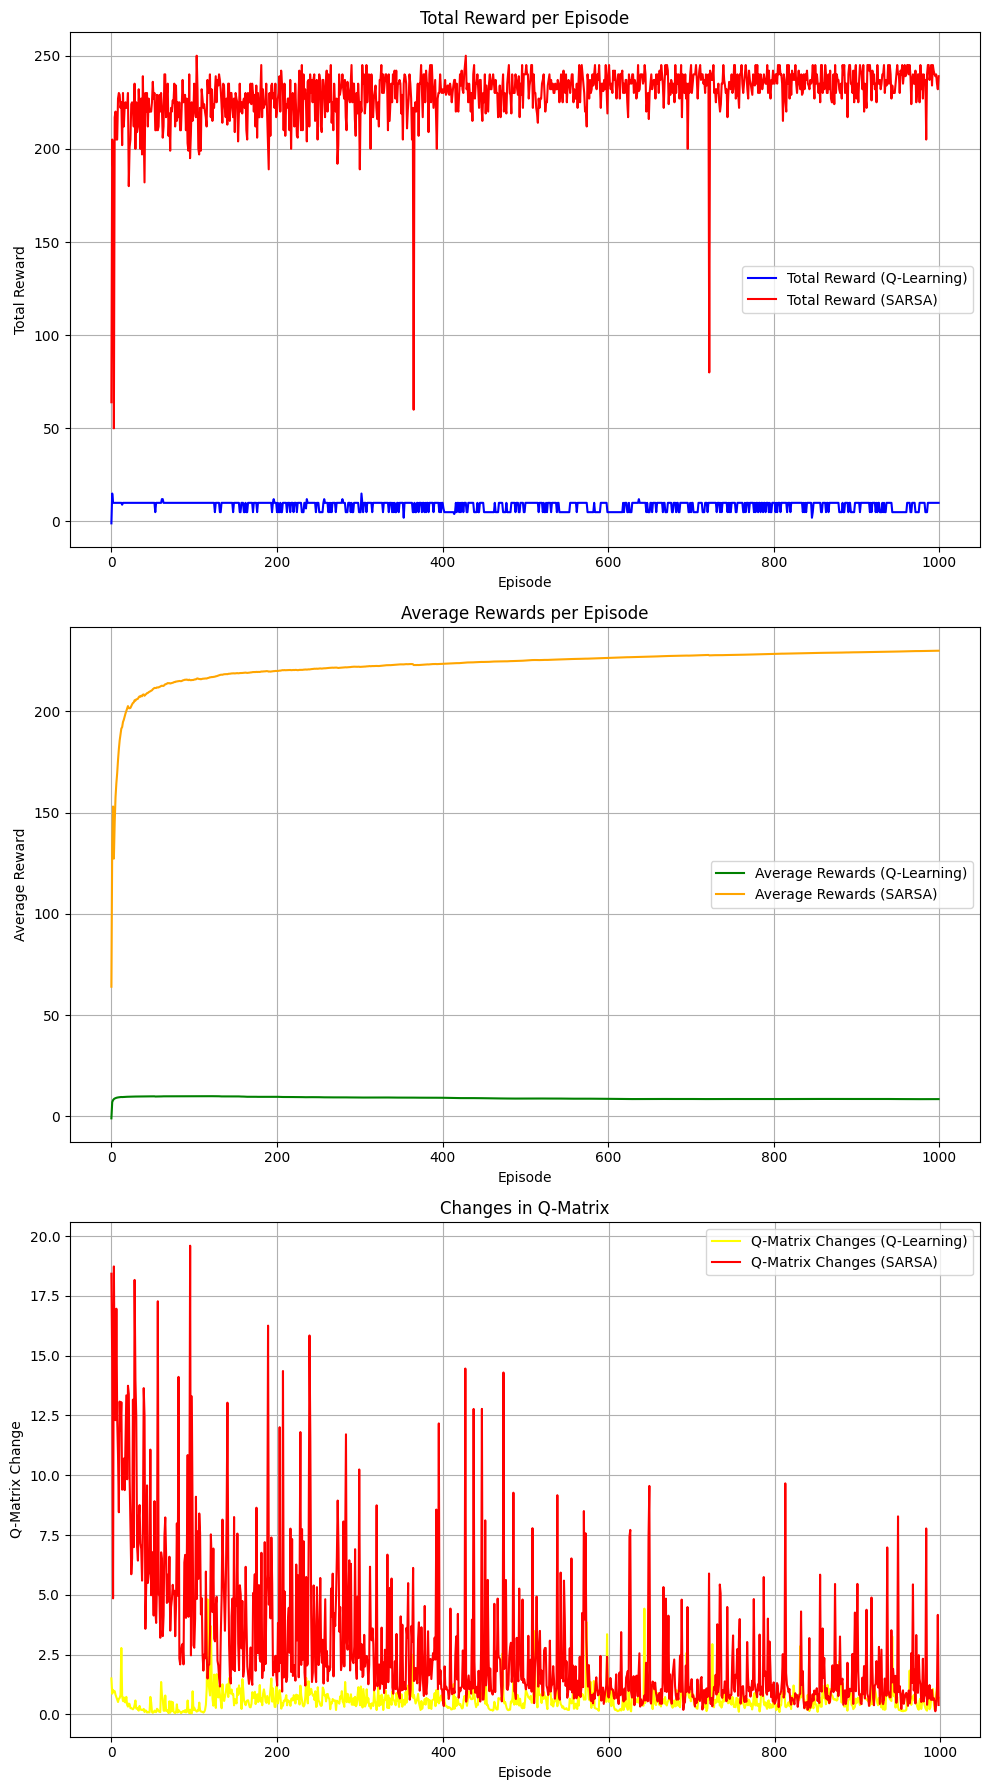

Optimal Path (Q-Learning): [(1, 0), (2, 0)]
Total Rewards for Optimal Path (Q-Learning): 0.0
Total Steps for Optimal Path (Q-Learning): 1
Number of animals visited on Optimal Path (Q-Learning): 1
Optimal Path (SARSA): [(1, 0), (0, 0)]
Total Rewards for Optimal Path (SARSA): 0.0
Total Steps for Optimal Path (SARSA): 1
Number of animals visited on Optimal Path (SARSA): 1


In [ ]:
# main.py
import matplotlib.pyplot as plt

# Initialize Q-Learning environment for Zoo
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': 0, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 5): (2, 4), (2, 4): (0, 5)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

# Visualize the environment
print(zoo_q_learning.visualise_world())

# Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

# Initialize SARSA environment for Zoo
zoo_sarsa = SARSA_learning(
    dims=(6, 6),
    rewards={'r_time': 0, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels= {(0, 5): (2, 4), (2, 4): (0, 5)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_sarsa.max_episodes = 1000

# Running SARSA learning
a_hist_sarsa, Q_hist_sarsa, Rtot_sarsa, animals_visited_hist_sarsa = zoo_sarsa.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

# Combine graphs for Q-Learning and SARSA
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Total Reward per Episode
axs[0].plot(Rtot_q, label='Total Reward (Q-Learning)', color='blue')
axs[0].plot(Rtot_sarsa, label='Total Reward (SARSA)', color='red')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Total Reward per Episode')
axs[0].legend()
axs[0].grid(True)

# Average Rewards per Episode
avg_rewards_q = (Rtot_q.cumsum() / (np.arange(len(Rtot_q)) + 1))
avg_rewards_sarsa = (Rtot_sarsa.cumsum() / (np.arange(len(Rtot_sarsa)) + 1))
axs[1].plot(avg_rewards_q, label='Average Rewards (Q-Learning)', color='green')
axs[1].plot(avg_rewards_sarsa, label='Average Rewards (SARSA)', color='orange')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Reward')
axs[1].set_title('Average Rewards per Episode')
axs[1].legend()
axs[1].grid(True)

# Changes in Q-Matrix
def plot_Q_changes(Q_hist, label, color):
    Q_diff = np.abs(Q_hist[1:] - Q_hist[:-1]).sum(axis=(1, 2))
    axs[2].plot(Q_diff, label=label, color=color)

plot_Q_changes(Q_hist_q, 'Q-Matrix Changes (Q-Learning)', 'yellow')
plot_Q_changes(Q_hist_sarsa, 'Q-Matrix Changes (SARSA)', 'red')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Q-Matrix Change')
axs[2].set_title('Changes in Q-Matrix')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Optimal paths and results for Q-Learning
optimal_path_q = find_path(Q_hist_q[-1])
optimal_path_grid_q = path_in_grids(optimal_path_q, zoo_q_learning._dims)
print("Optimal Path (Q-Learning):", optimal_path_grid_q)
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)

# Optimal paths and results for SARSA
optimal_path_sarsa = find_path(Q_hist_sarsa[-1])
optimal_path_grid_sarsa = path_in_grids(optimal_path_sarsa, zoo_sarsa._dims)
print("Optimal Path (SARSA):", optimal_path_grid_sarsa)
total_rewards_sarsa, steps_sarsa = calculate_rewards(zoo_sarsa._R, optimal_path_sarsa)
print("Total Rewards for Optimal Path (SARSA):", total_rewards_sarsa)
print("Total Steps for Optimal Path (SARSA):", steps_sarsa)
animals_visited_sarsa = len(animals_positions.intersection(optimal_path_grid_sarsa))
print("Number of animals visited on Optimal Path (SARSA):", animals_visited_sarsa)


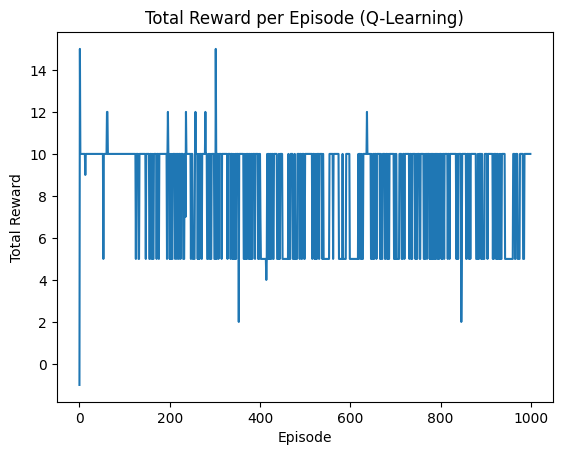

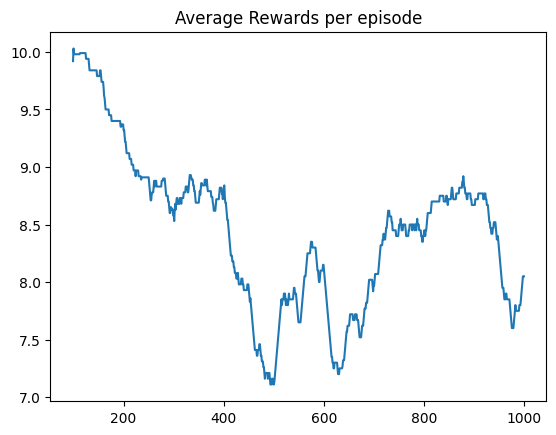

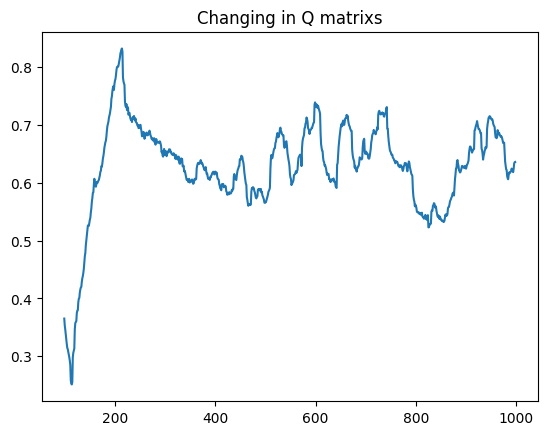

Optimal Path (Q-Learning): [(1, 0), (2, 0)]
Total Rewards for Optimal Path (Q-Learning): 0.0
Total Steps for Optimal Path (Q-Learning): 1
Number of animals visited on Optimal Path (Q-Learning): 1


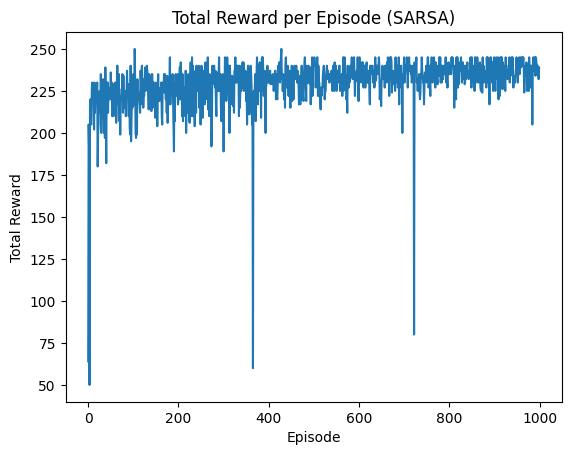

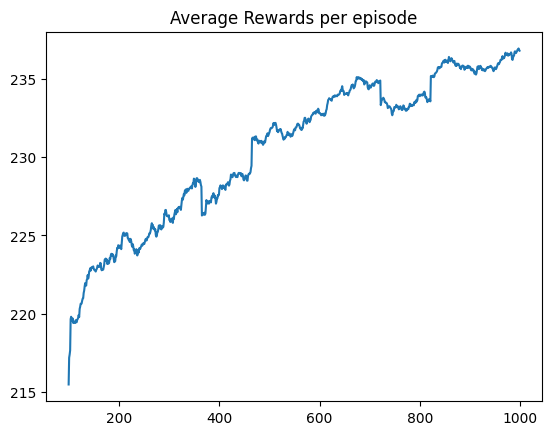

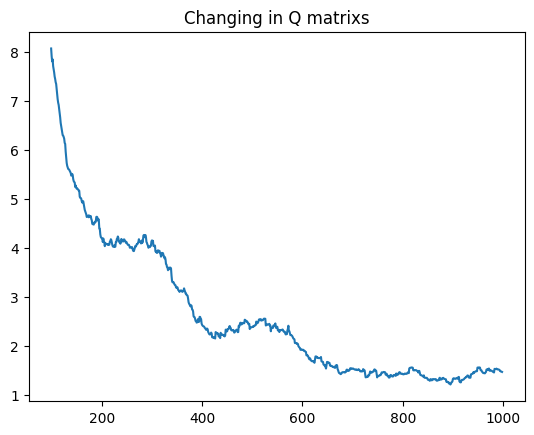

Optimal Path (SARSA): [(1, 0), (0, 0)]
Total Rewards for Optimal Path (SARSA): 0.0
Total Steps for Optimal Path (SARSA): 1
Number of animals visited on Optimal Path (SARSA): 1


In [ ]:
# main.py
import matplotlib.pyplot as plt

#Initialize Q-Learning environment for Zoo
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': 0, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels= {(0, 5): (2, 4), (2, 4): (0, 5)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#avg rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#changes in Q-matrix
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
optimal_path_grid_q = path_in_grids(optimal_path_q, zoo_q_learning._dims)
print("Optimal Path (Q-Learning):", optimal_path_grid_q)

#Q-learning results
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

#number of unique animals visited on the optimal path
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


#Initialize SARSA environment for Zoo
zoo_sarsa = SARSA_learning(
    dims=(6, 6),
    rewards={'r_time': 0, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -2, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels= {(0, 5): (2, 4), (2, 4): (0, 5)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_sarsa.max_episodes = 1000

#Running SARSA learning
a_hist_sarsa, Q_hist_sarsa, Rtot_sarsa, animals_visited_hist_sarsa = zoo_sarsa.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results for SARSA
plt.plot(Rtot_sarsa)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (SARSA)')
plt.show()

#average rewards per episode for SARSA
average_R_display(Rtot_sarsa, rolling_periods=100)

#changes in Q-matrix for SARSA
plot_Q_changing(Q_hist_sarsa, rolling_periods=100)

#optimal path for SARSA
optimal_path_sarsa = find_path(Q_hist_sarsa[-1])
optimal_path_grid_sarsa = path_in_grids(optimal_path_sarsa, zoo_sarsa._dims)
print("Optimal Path (SARSA):", optimal_path_grid_sarsa)

#total rewards and steps for the optimal path for SARSA
total_rewards_sarsa, steps_sarsa = calculate_rewards(zoo_sarsa._R, optimal_path_sarsa)
print("Total Rewards for Optimal Path (SARSA):", total_rewards_sarsa)
print("Total Steps for Optimal Path (SARSA):", steps_sarsa)

#number of unique animals visited on the optimal path
animals_visited_sarsa = len(animals_positions.intersection(optimal_path_grid_sarsa))
print("Number of animals visited on Optimal Path (SARSA):", animals_visited_sarsa)

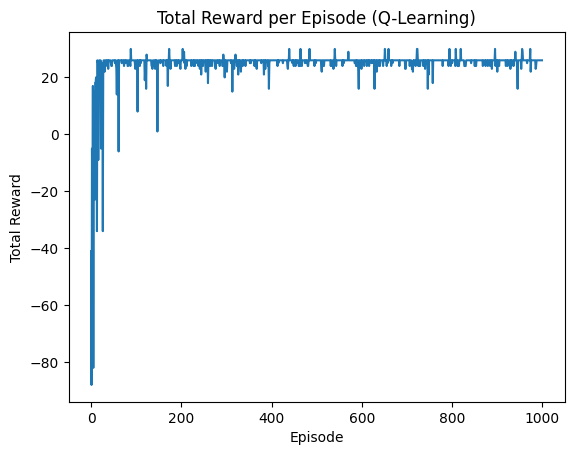

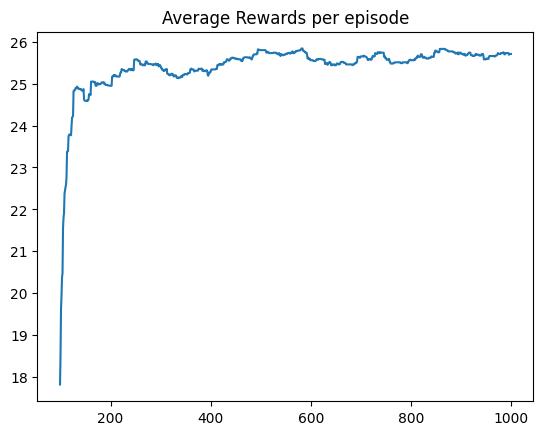

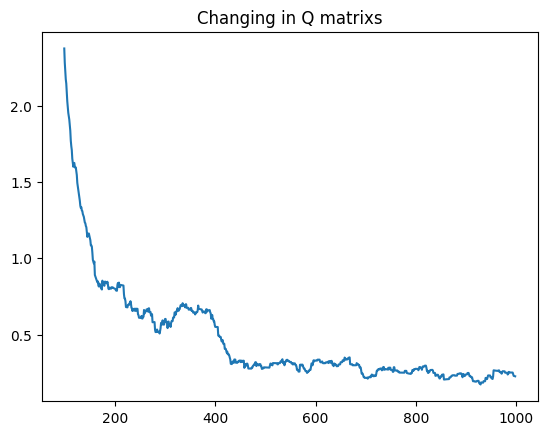

Optimal Path (Q-Learning): [(1, 0), (0, 1), (0, 3), (0, 0), (0, 2)]
Total Rewards for Optimal Path (Q-Learning): nan
Total Steps for Optimal Path (Q-Learning): 4
Number of animals visited on Optimal Path (Q-Learning): 2


In [ ]:
#Experiment 1
import matplotlib.pyplot as plt

#Initialize Q-Learning environment for Zoo
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -1, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -5, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#run Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
optimal_path_grid_q = path_in_grids(optimal_path_q, zoo_q_learning._dims)
print("Optimal Path (Q-Learning):", optimal_path_grid_q)

#total rewards and steps for the optimal path for Q-learning
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

#number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


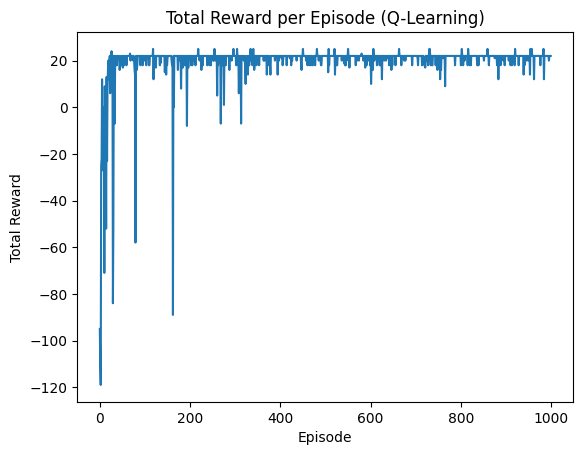

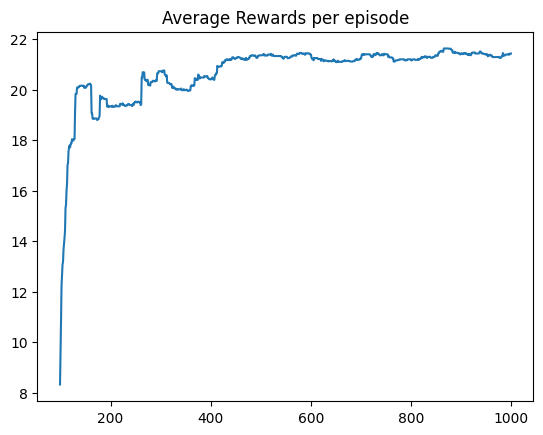

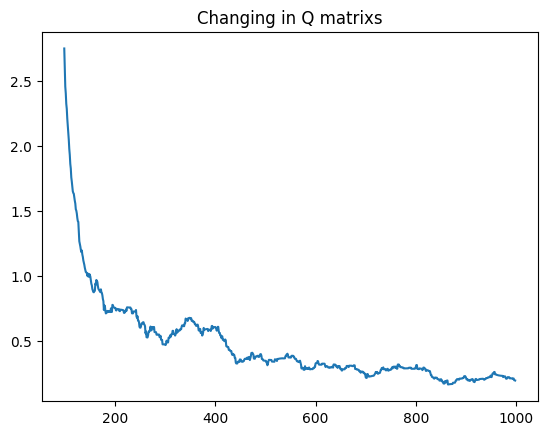

Optimal Path (Q-Learning): [(1, 0), (0, 1), (0, 3), (0, 0), (0, 2)]
Total Rewards for Optimal Path (Q-Learning): nan
Total Steps for Optimal Path (Q-Learning): 4
Number of animals visited on Optimal Path (Q-Learning): 2


In [ ]:
#Experiment 2
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 25, 'r_exit_partial': -7, 'r_tunnel1': -5, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},

    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000
#Run Q-learning
a_hist_q, Q_hist_q, Rtot_q,animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#Results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
print("Optimal Path (Q-Learning):", path_in_grids(optimal_path_q, zoo_q_learning._dims))

#total rewards and steps for the optimal path for Q-learning
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)
# Count the number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)




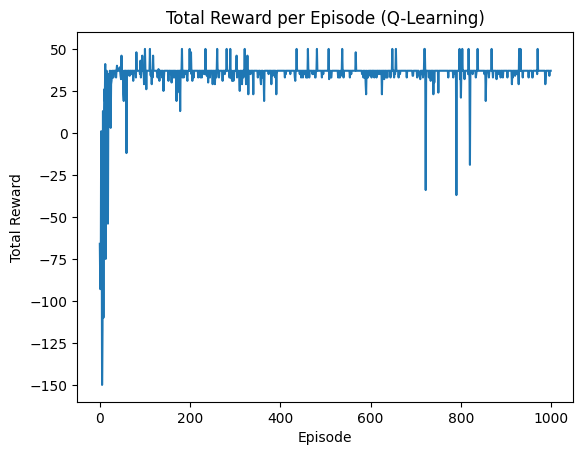

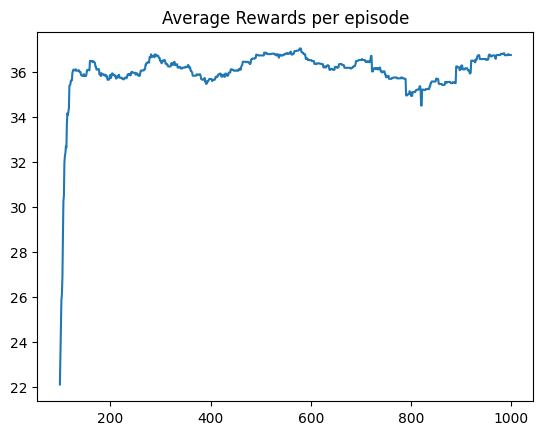

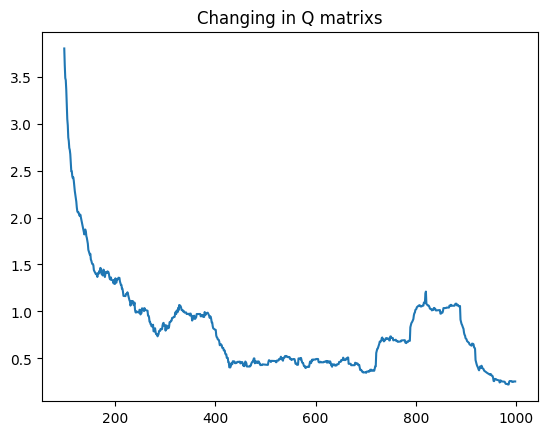

Optimal Path (Q-Learning): [(1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (0, 0), (0, 2)]
Total Rewards for Optimal Path (Q-Learning): nan
Total Steps for Optimal Path (Q-Learning): 10
Number of animals visited on Optimal Path (Q-Learning): 3


In [ ]:
#experiment 3:
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -3, 'r_animal': 15, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#Run Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
print("Optimal Path (Q-Learning):", path_in_grids(optimal_path_q, zoo_q_learning._dims))

#total rewards and steps for the optimal path for Q-learning
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

# Count the number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
optimal_path_grid_q = path_in_grids(optimal_path_q, zoo_q_learning._dims)
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


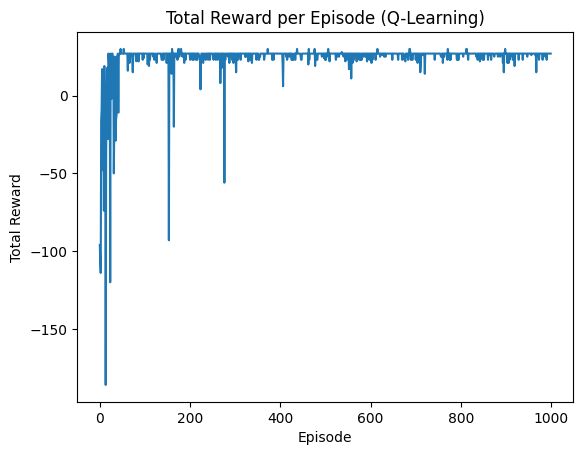

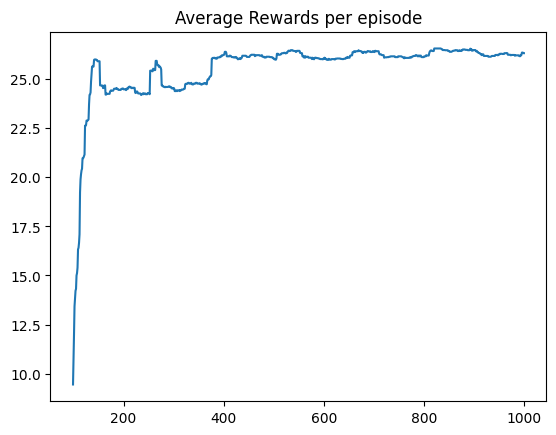

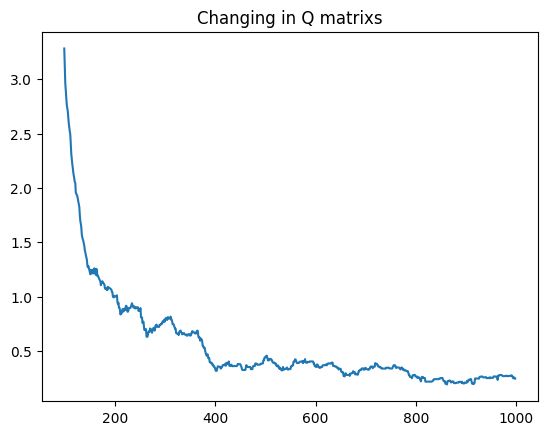

Optimal Path (Q-Learning): [(1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (0, 0), (0, 2)]
Total Rewards for Optimal Path (Q-Learning): nan
Total Steps for Optimal Path (Q-Learning): 10
Number of animals visited on Optimal Path (Q-Learning): 3


In [ ]:
#experiment 4:
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},  # Changed from list to dictionary
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#Run Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
print("Optimal Path (Q-Learning):", path_in_grids(optimal_path_q, zoo_q_learning._dims))

#total rewards and steps for the optimal path for Q-learning
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

# Count the number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
optimal_path_grid_q = path_in_grids(optimal_path_q, zoo_q_learning._dims)
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


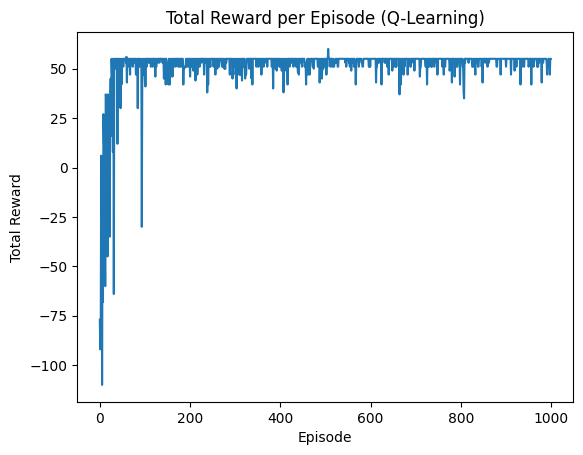

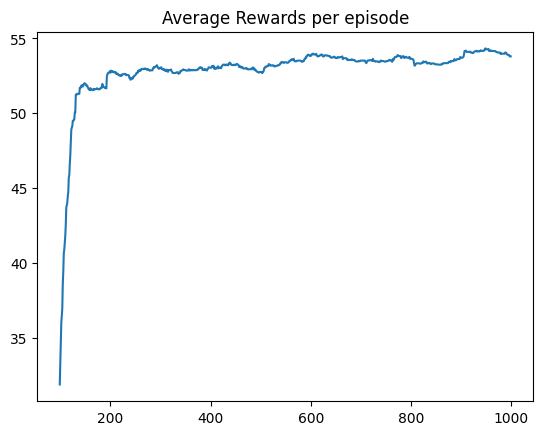

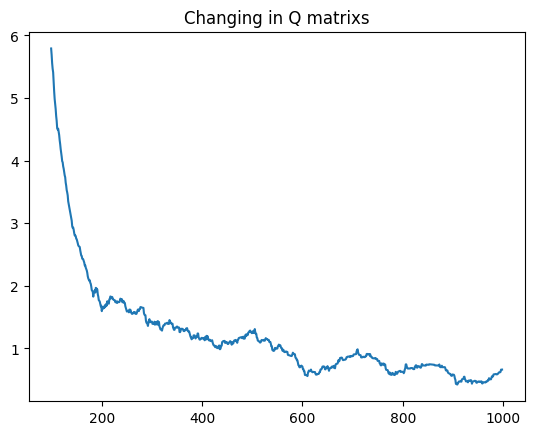

Optimal Path (Q-Learning): [(1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (4, 2), (4, 3), (5, 3), (5, 4), (4, 4), (4, 5), (0, 0), (0, 2)]
Total Rewards for Optimal Path (Q-Learning): nan
Total Steps for Optimal Path (Q-Learning): 12
Number of animals visited on Optimal Path (Q-Learning): 4


In [ ]:
#Experiment 5

import matplotlib.pyplot as plt

#Q-Learning initialization
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 15, 'r_exit_all': 35, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_hist_q = zoo_q_learning.learn(alpha=0.1, gamma=0.9, epsilon=0.1)

#results of Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#Avg rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

#Q-matrix of Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
print("Optimal Path (Q-Learning):", path_in_grids(optimal_path_q, zoo_q_learning._dims))

#Total rewards Vs steps for the optimal path for Q-learning
total_rewards, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

#No. of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
optimal_path_grid_q = set((cell // zoo_q_learning._dims[1], cell % zoo_q_learning._dims[0]) for cell in optimal_path_q)
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


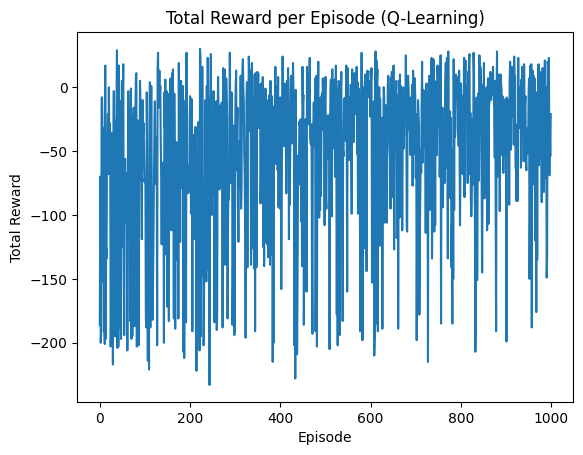

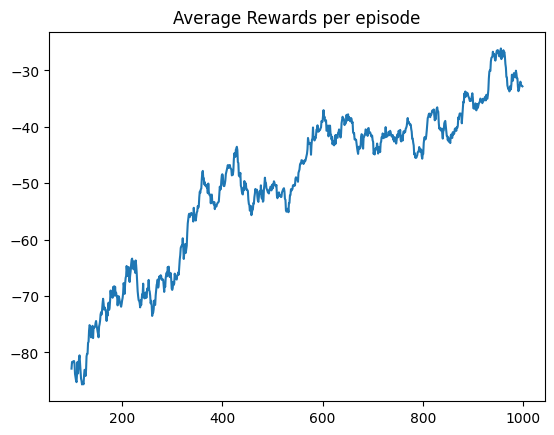

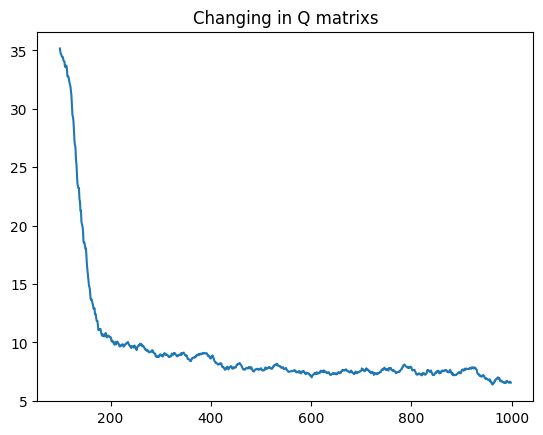

Optimal Path (Q-Learning): [(1, 0), (0, 0), (1, 5), (2, 5), (3, 5), (4, 5)]
Total Rewards for Optimal Path (Q-Learning): 24.0
Total Steps for Optimal Path (Q-Learning): 5
Number of animals visited on Optimal Path (Q-Learning): 2


In [ ]:
#Experiment 6
import matplotlib.pyplot as plt

# Initialize Q-Learning environment for Zoo
zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -3, 'r_animal': 5, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 10},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

# Run Q-learning
a_hist_q, Q_hist_q, Rtot_q, animals_visited_q = zoo_q_learning.learn(alpha=0.3, gamma=0.95, epsilon=0.9)

# results for Q-learning
plt.plot(Rtot_q)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Q-Learning)')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q, rolling_periods=100)

# changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q, rolling_periods=100)

#the optimal path for Q-learning
optimal_path_q = find_path(Q_hist_q[-1])
print("Optimal Path (Q-Learning):", path_in_grids(optimal_path_q, zoo_q_learning._dims))

# total rewards and steps for the optimal path for Q-learning
total_rewards_q, steps_q = calculate_rewards(zoo_q_learning._R, optimal_path_q)
print("Total Rewards for Optimal Path (Q-Learning):", total_rewards_q)
print("Total Steps for Optimal Path (Q-Learning):", steps_q)

#number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
animals_visited_q = len(animals_positions.intersection(optimal_path_grid_q))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q)


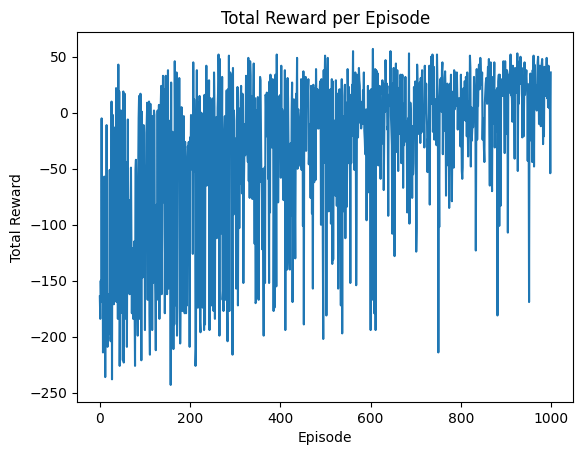

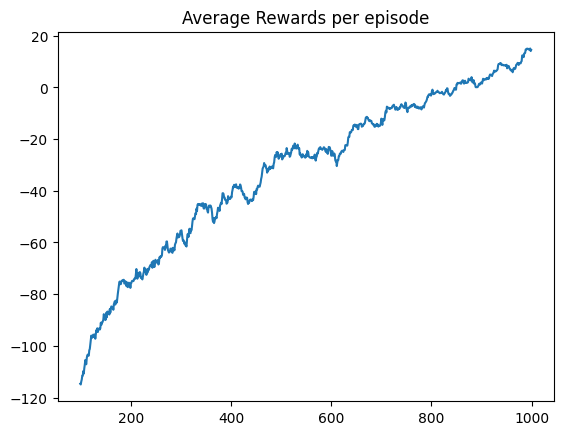

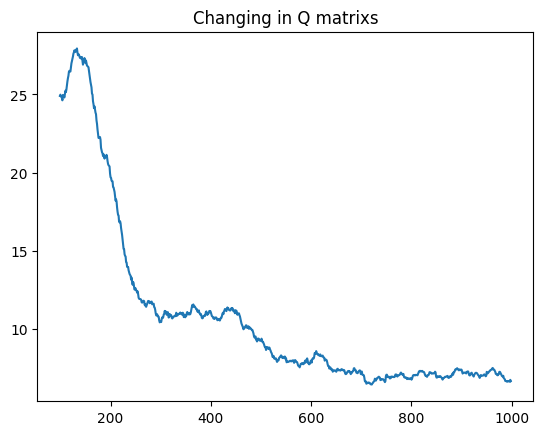

Optimal Path (Q-Learning) - Experiment 5: [(1, 0), (0, 0), (1, 5), (2, 5), (3, 5), (4, 5)]
Total Rewards for Optimal Path (Q-Learning) - Experiment 5: 39.0
Total Steps for Optimal Path (Q-Learning) - Experiment 5: 5
Number of animals visited on Optimal Path (Q-Learning): 2


In [ ]:
#Experiment 7
import matplotlib.pyplot as plt

#Q-learning initialization
zoo_q_learning_exp5 = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 15, 'r_exit_all': 35, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},  # Changed from list to dictionary
    epsilon_decays={'epsilon_threshold': 0.05, 'epsilon_decay1': 0.9996, 'epsilon_decay2': 0.9991}
)
zoo_q_learning_exp5.max_episodes = 5000

# Run Q-learning
a_hist_q_exp5, Q_hist_q_exp5, Rtot_q_exp5, animals_visited_q_exp5 = zoo_q_learning_exp5.learn(alpha=0.15, gamma=0.9, epsilon=1.0)

#esults for Q-learning
plt.plot(Rtot_q_exp5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

#average rewards per episode for Q-learning
average_R_display(Rtot_q_exp5, rolling_periods=100)

#changes in Q-matrix for Q-learning
plot_Q_changing(Q_hist_q_exp5, rolling_periods=100)

#optimal path for Q-learning
optimal_path_q_exp5 = find_path(Q_hist_q_exp5[-1])
print("Optimal Path (Q-Learning) - Experiment 5:", path_in_grids(optimal_path_q_exp5, zoo_q_learning_exp5._dims))

#total rewards and steps for the optimal path for Q-learning
total_rewards_q_exp5, steps_q_exp5 = calculate_rewards(zoo_q_learning_exp5._R, optimal_path_q_exp5)
print("Total Rewards for Optimal Path (Q-Learning) - Experiment 5:", total_rewards_q_exp5)
print("Total Steps for Optimal Path (Q-Learning) - Experiment 5:", steps_q_exp5)

#number of unique animals visited on the optimal path for Q-learning
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning_exp5._positions['animal'])
optimal_path_grid_q_exp5 = path_in_grids(optimal_path_q_exp5, zoo_q_learning_exp5._dims)
animals_visited_q_exp5 = len(animals_positions.intersection(optimal_path_grid_q_exp5))
print("Number of animals visited on Optimal Path (Q-Learning):", animals_visited_q_exp5)


Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.3
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.3
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.2
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.2
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.99, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.99, epsilon=0.2
Testing configura

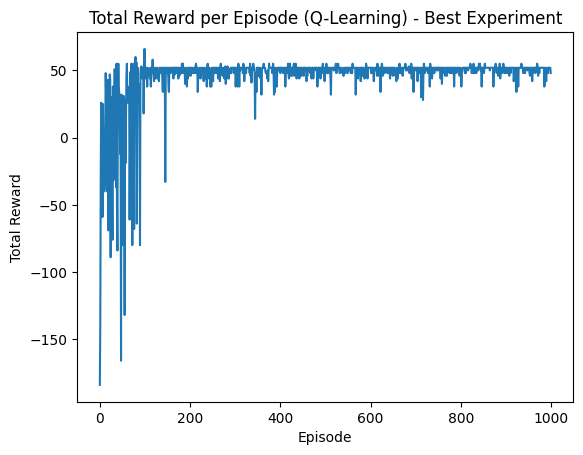

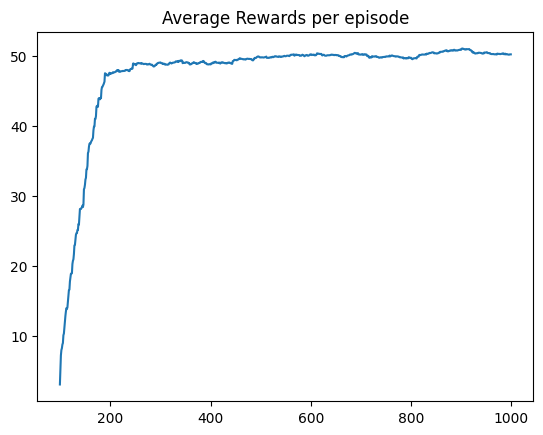

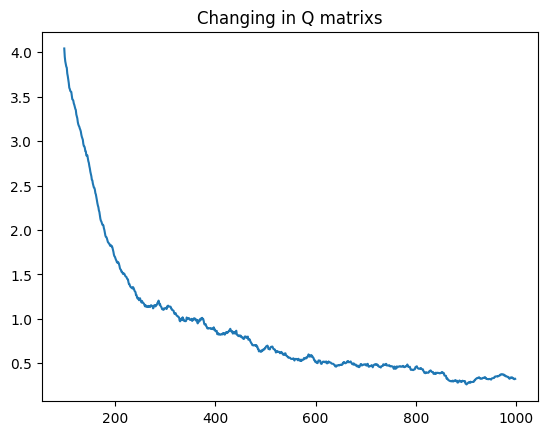

Optimal Path (Q-Learning) - Best Experiment: [(1, 0), (0, 0), (1, 5), (2, 5), (3, 5), (4, 5)]
Total Rewards for Optimal Path (Q-Learning) - Best Experiment: 39.0
Total Steps for Optimal Path (Q-Learning) - Best Experiment: 5
Number of animals visited on Optimal Path (Q-Learning) - Best Experiment: 2
The best hyperparameters are: alpha=0.05, gamma=0.8, epsilon=0.2


In [ ]:
import matplotlib.pyplot as plt
from itertools import product

#hyperparameters ranges for tuning
alpha_values = [0.05, 0.1, 0.2]
gamma_values = [0.8, 0.9, 0.99]
epsilon_values = [0.1, 0.2, 0.3]

# the best configuration initialization
best_total_reward = float('-inf')
best_config = {}
best_Q_hist = None
best_a_hist = None
best_Rtot = None

#Grid search on hyperparameters
for alpha, gamma, epsilon in product(alpha_values, gamma_values, epsilon_values):
    print(f"Testing configuration: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

    #initialize Q-Learning
    zoo_q_learning_exp5 = Q_Learning(
        dims=(6, 6),
        rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 15, 'r_exit_all': 35, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
        start=(3, 0),
        end=(4, 5),
        positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
        tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},  # Changed from list to dictionary
        epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
    )
    zoo_q_learning_exp5.max_episodes = 1000

    # Run Q-learning
    a_hist_q_exp5, Q_hist_q_exp5, Rtot_q_exp5, animals_visited_hist_q_exp5 = zoo_q_learning_exp5.learn(alpha=alpha, gamma=gamma, epsilon=epsilon)

    #total rewards for the optimal path calculation
    optimal_path_q_exp5 = find_path(Q_hist_q_exp5[-1])
    total_rewards_q_exp5, _ = calculate_rewards(zoo_q_learning_exp5._R, optimal_path_q_exp5)

    #the best configuration if the current one is better
    if total_rewards_q_exp5 > best_total_reward:
        best_total_reward = total_rewards_q_exp5
        best_config = {'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon}
        best_Q_hist = Q_hist_q_exp5
        best_a_hist = a_hist_q_exp5
        best_Rtot = Rtot_q_exp5

# Output of the best configuration and results
print(f"Best configuration: {best_config}")
print(f"Best total reward: {best_total_reward}")

#results for the best Q-learning experiment
plt.plot(best_Rtot)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f"Total Reward per Episode (Q-Learning) - Best Experiment")
plt.show()

# average rewards per episode for the best Q-learning
average_R_display(best_Rtot, rolling_periods=100)

# changes in Q-matrix for the best Q-learning
plot_Q_changing(best_Q_hist, rolling_periods=100)

# the optimal path for the best Q-learning
optimal_path_best = find_path(best_Q_hist[-1])
optimal_path_grid_best = path_in_grids(optimal_path_best, zoo_q_learning_exp5._dims)
print("Optimal Path (Q-Learning) - Best Experiment:", optimal_path_grid_best)

#total rewards and steps for the optimal path for the best Q-learning
total_rewards_best, steps_best = calculate_rewards(zoo_q_learning_exp5._R, optimal_path_best)
print("Total Rewards for Optimal Path (Q-Learning) - Best Experiment:", total_rewards_best)
print("Total Steps for Optimal Path (Q-Learning) - Best Experiment:", steps_best)

#number of unique animals visited on the optimal path for the best experiment
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning_exp5._positions['animal'])
animals_visited_best = len(animals_positions.intersection(optimal_path_grid_best))
print("Number of animals visited on Optimal Path (Q-Learning) - Best Experiment:", animals_visited_best)

# Print the best configuration
print(f"The best hyperparameters are: alpha={best_config['alpha']}, gamma={best_config['gamma']}, epsilon={best_config['epsilon']}")


Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.8, epsilon=0.3
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.9, epsilon=0.3
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.1
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.2
Testing configuration: alpha=0.05, gamma=0.99, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.2
Testing configuration: alpha=0.1, gamma=0.8, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.2
Testing configuration: alpha=0.1, gamma=0.9, epsilon=0.3
Testing configuration: alpha=0.1, gamma=0.99, epsilon=0.1
Testing configuration: alpha=0.1, gamma=0.99, epsilon=0.2
Testing configura

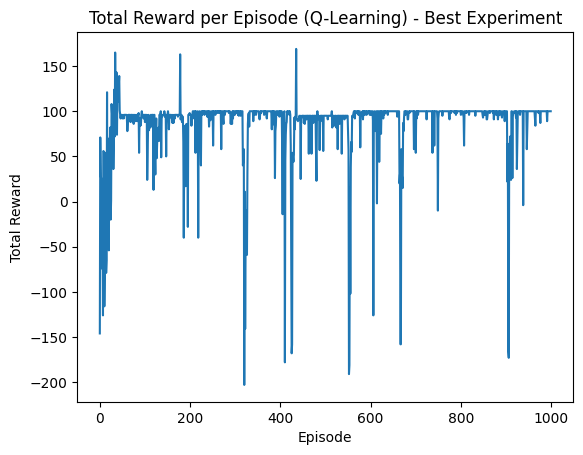

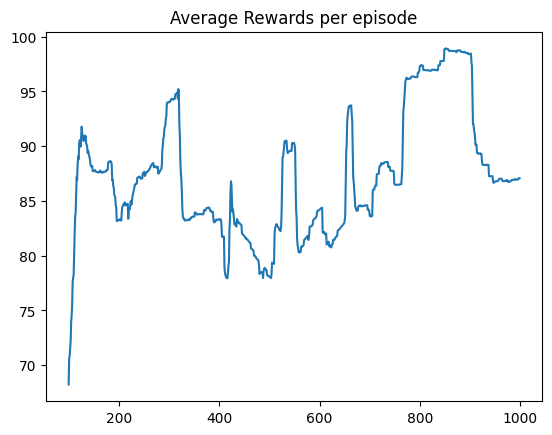

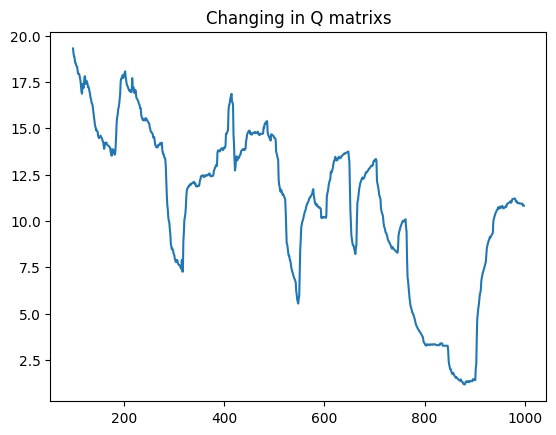

Optimal Path (Q-Learning) - Best Experiment: [(1, 0), (0, 0), (0, 1), (0, 2), (1, 2), (4, 1), (4, 2), (4, 3), (5, 3), (5, 4), (4, 4), (4, 5)]
Total Rewards for Optimal Path (Q-Learning) - Best Experiment: 131.0
Total Steps for Optimal Path (Q-Learning) - Best Experiment: 11
Number of animals visited on Optimal Path (Q-Learning) - Best Experiment: 4
The best hyperparameters are: alpha=0.2, gamma=0.9, epsilon=0.1


In [ ]:
#updating rewards for animal visits
import matplotlib.pyplot as plt
from itertools import product

# hyperparameters ranges for tuning
alpha_values = [0.05, 0.1, 0.2]
gamma_values = [0.8, 0.9, 0.99]
epsilon_values = [0.1, 0.2, 0.3]

#the best configuration initialization
best_total_reward = float('-inf')
best_config = {}
best_Q_hist = None
best_a_hist = None
best_Rtot = None

#Grid search on hyperparameters
for alpha, gamma, epsilon in product(alpha_values, gamma_values, epsilon_values):
    print(f"Testing configuration: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

    #Q-Learning environment for Zoo with new parameters initializatiom
    zoo_q_learning_exp5 = Q_Learning(
        dims=(6, 6),
        rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 40, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
        start=(3, 0),
        end=(4, 5),
        positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
        tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
        epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
    )
    zoo_q_learning_exp5.max_episodes = 1000

    #Run Q-learning with the new configuration
    a_hist_q_exp5, Q_hist_q_exp5, Rtot_q_exp5, animals_visited_hist_q_exp5 = zoo_q_learning_exp5.learn(alpha=alpha, gamma=gamma, epsilon=epsilon)

    #calculate the total rewards for the optimal path
    optimal_path_q_exp5 = find_path(Q_hist_q_exp5[-1])
    total_rewards_q_exp5, _ = calculate_rewards(zoo_q_learning_exp5._R, optimal_path_q_exp5)

    #Update the best configuration if the current one is better
    if total_rewards_q_exp5 > best_total_reward:
        best_total_reward = total_rewards_q_exp5
        best_config = {'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon}
        best_Q_hist = Q_hist_q_exp5
        best_a_hist = a_hist_q_exp5
        best_Rtot = Rtot_q_exp5

#Output of the best configuration and results
print(f"Best configuration: {best_config}")
print(f"Best total reward: {best_total_reward}")

#results for the best Q-learning
plt.plot(best_Rtot)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f"Total Reward per Episode (Q-Learning) - Best Experiment")
plt.show()

#average rewards per episode for the best Q-learning
average_R_display(best_Rtot, rolling_periods=100)

# changes in Q-matrix for the best Q-learning
plot_Q_changing(best_Q_hist, rolling_periods=100)

#optimal path for the best Q-learning experient
optimal_path_best = find_path(best_Q_hist[-1])
optimal_path_grid_best = path_in_grids(optimal_path_best, zoo_q_learning_exp5._dims)
print("Optimal Path (Q-Learning) - Best Experiment:", optimal_path_grid_best)

#total rewards and steps for the optimal path for the best Q-learning experiment
total_rewards_best, steps_best = calculate_rewards(zoo_q_learning_exp5._R, optimal_path_best)
print("Total Rewards for Optimal Path (Q-Learning) - Best Experiment:", total_rewards_best)
print("Total Steps for Optimal Path (Q-Learning) - Best Experiment:", steps_best)

#number of unique animals visited on the optimal path for the best experiment
animals_positions = set((animal[0], animal[1]) for animal in zoo_q_learning_exp5._positions['animal'])
animals_visited_best = len(animals_positions.intersection(optimal_path_grid_best))
print("Number of animals visited on Optimal Path (Q-Learning) - Best Experiment:", animals_visited_best)

# Print the best configuration
print(f"The best hyperparameters are: alpha={best_config['alpha']}, gamma={best_config['gamma']}, epsilon={best_config['epsilon']}")


Any NaNs in Q_hist?: False
Any NaNs in Rtot?: False
Path: [6, 0, 1, 2, 8, 25, 26, 27, 33, 34, 28, 29]
Path in grid coords: [(1, 0), (0, 0), (0, 1), (0, 2), (1, 2), (4, 1), (4, 2), (4, 3), (5, 3), (5, 4), (4, 4), (4, 5)]
Total Rewards: 131.0
Number of steps: 11
Number of animals visited on Optimal Path: 4
The best hyperparameters are: alpha=0.2, gamma=0.9, epsilon=0.1


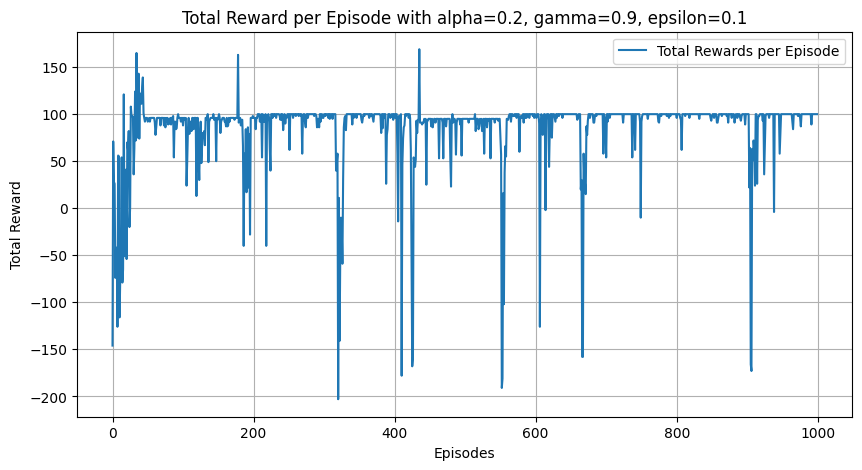

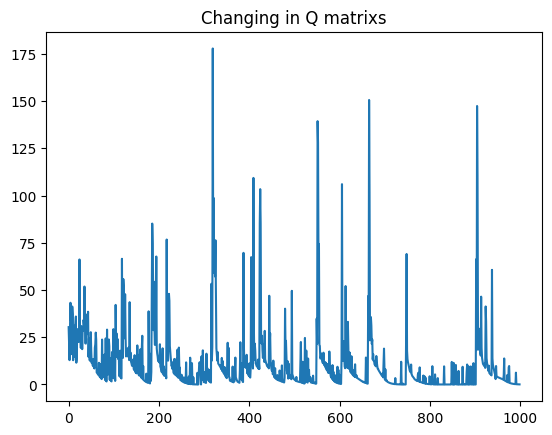

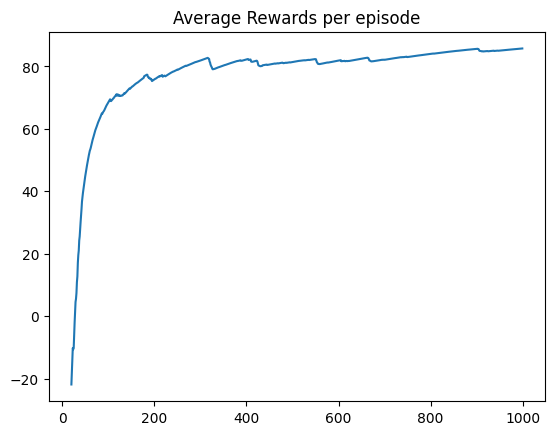

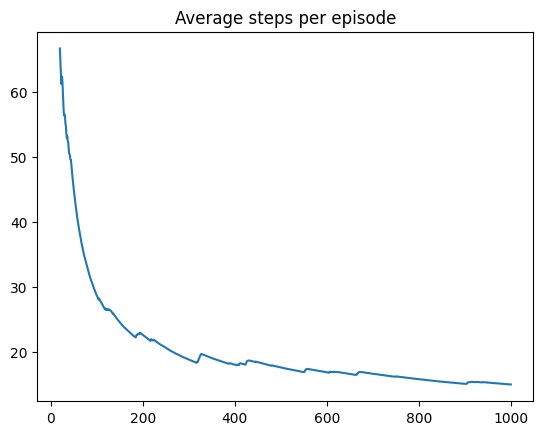

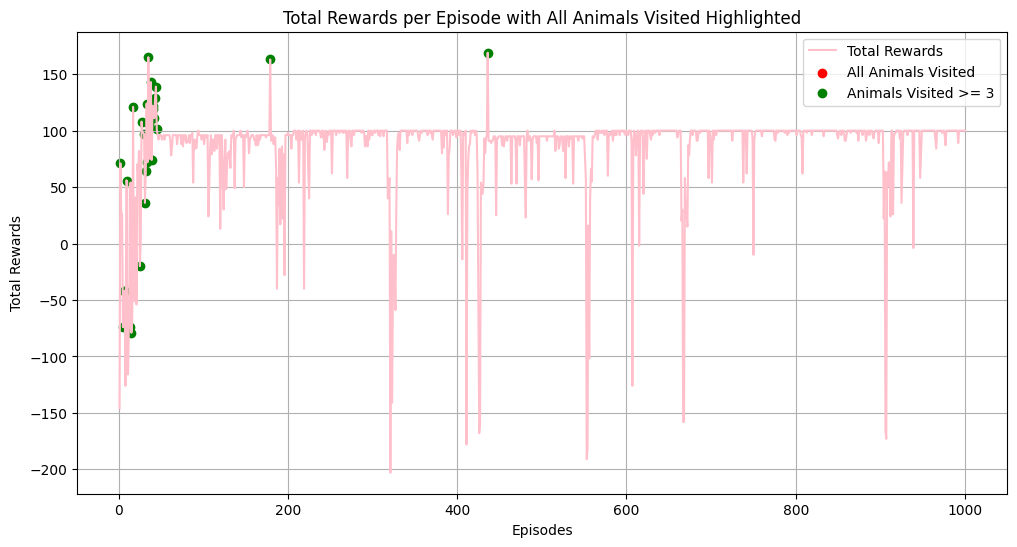

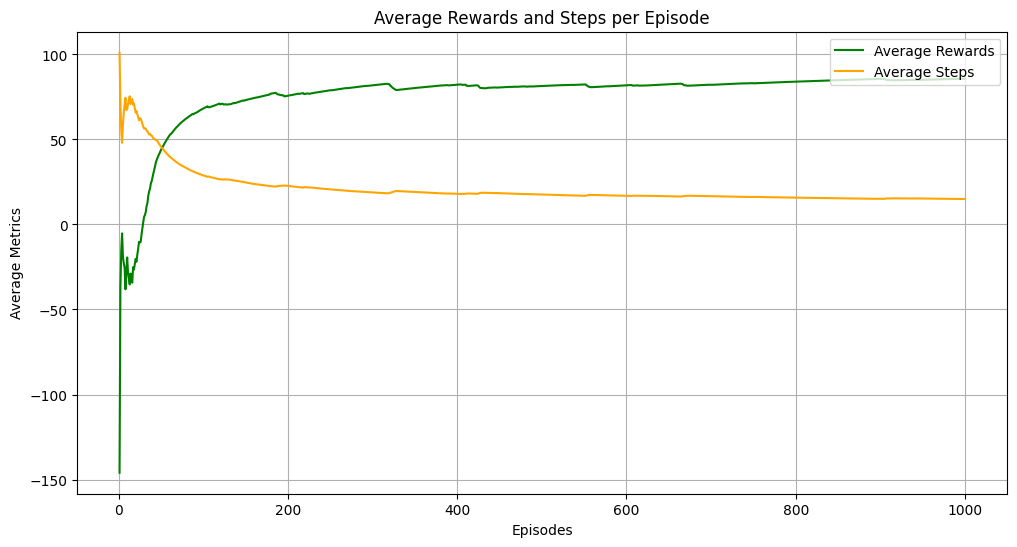

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 40, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 1000

#Best hyperparameters
alpha = 0.2
gamma = 0.9
epsilon = 0.1

# Run Q-learning with the best found hyperparameters
a_hist, Q_hist, Rtot, animals_visited_hist = zoo_q_learning.learn(alpha, gamma, epsilon)

#Check for any NaN values in Q_hist and Rtot
print("Any NaNs in Q_hist?:", np.isnan(Q_hist).any())
print("Any NaNs in Rtot?:", np.isnan(Rtot).any())

#optimal path
path = find_path(Q_hist[-1])
r, steps = calculate_rewards(zoo_q_learning._R, path)
print("Path:", path)
print("Path in grid coords:", path_in_grids(path, zoo_q_learning._dims))
print("Total Rewards:", r)
print("Number of steps:", steps)

#number of unique animals visited on the optimal path
animal_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
optimal_path_grid = path_in_grids(path, zoo_q_learning._dims)
animals_visited = len(animal_positions.intersection(optimal_path_grid))
print("Number of animals visited on Optimal Path:", animals_visited)

print(f"The best hyperparameters are: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

# total rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(Rtot, label='Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title(f'Total Reward per Episode with alpha={alpha}, gamma={gamma}, epsilon={epsilon}')
plt.legend()
plt.grid(True)
plt.show()


# Q-matrix changes, average reward, and steps
plot_Q_changing(Q_hist, absolute=True)
average_R_display(Rtot)
steps_plot(a_hist)

episodes = np.arange(1, len(Rtot) + 1)  #No. of episodes
rewards = Rtot  #Total rewards collected in each episode
steps = np.array([len(hist) for hist in a_hist])  # No. of steps in each episode

#all animals were visited or not in each episode
all_animals_visited = np.array([
    len(animal_positions.intersection(path_in_grids(find_path(Q_hist[i]), zoo_q_learning._dims))) == len(animal_positions)
    for i in range(len(Q_hist))
])

#Check for episodes where the number of animals visited is >= 3
animals_visited_ge_3 = np.array(animals_visited_hist >= 3)

# Graph 1: All animals visited with exit and rewards collected
plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Total Rewards', color='pink')
plt.scatter(episodes[all_animals_visited], rewards[all_animals_visited], color='red', label='All Animals Visited')
plt.scatter(episodes[animals_visited_ge_3], rewards[animals_visited_ge_3], color='green', label='Animals Visited >= 3')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Episode with All Animals Visited Highlighted')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Graph 2: Average rewards collected each episode and steps
avg_rewards = np.cumsum(rewards) / episodes
avg_steps = np.cumsum(steps) / episodes

plt.figure(figsize=(12, 6))
plt.plot(episodes, avg_rewards, label='Average Rewards', color='green')
plt.plot(episodes, avg_steps, label='Average Steps', color='orange')
plt.xlabel('Episodes')
plt.ylabel('Average Metrics')
plt.title('Average Rewards and Steps per Episode')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Any NaNs in Q_hist?: False
Any NaNs in Rtot?: False
Path: [6, 1, 3, 2, 8, 25, 19, 20, 26, 27, 33, 34, 28, 29, 0, 11, 17, 23]
Path in grid coords: [(1, 0), (0, 1), (0, 3), (0, 2), (1, 2), (4, 1), (3, 1), (3, 2), (4, 2), (4, 3), (5, 3), (5, 4), (4, 4), (4, 5), (0, 0), (1, 5), (2, 5), (3, 5)]
Total Rewards: nan
Number of steps: 17
Number of animals visited on Optimal Path: 5
The best hyperparameters are: alpha=0.2, gamma=0.9, epsilon=0.1


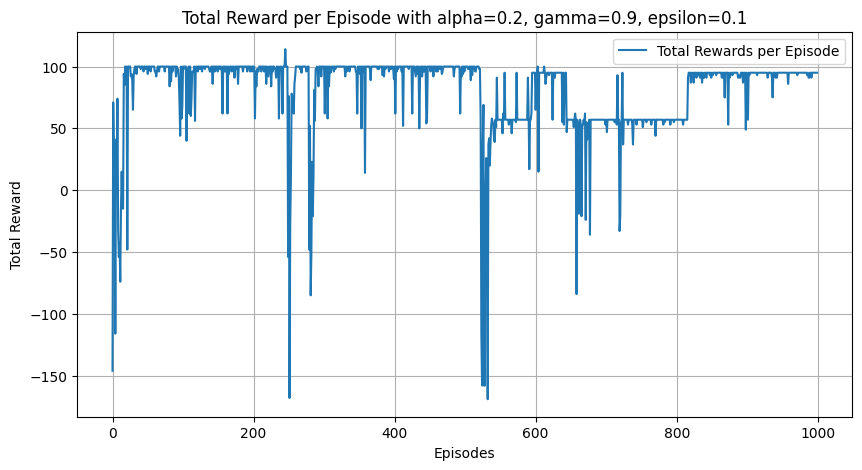

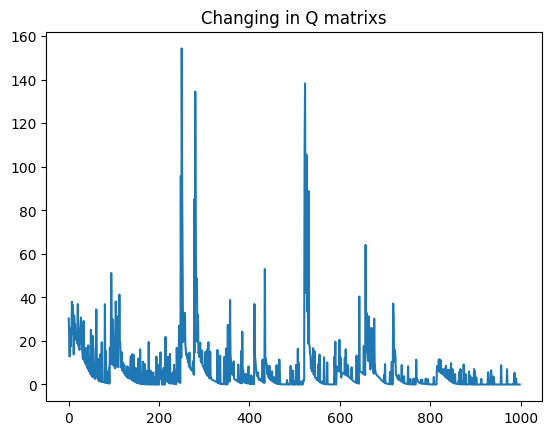

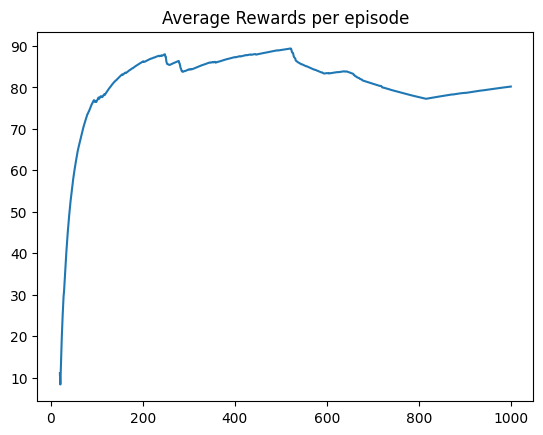

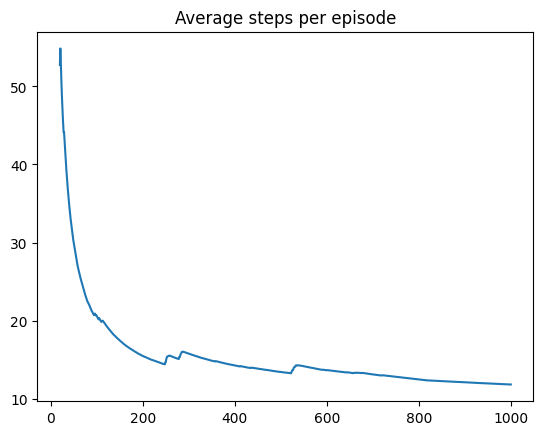

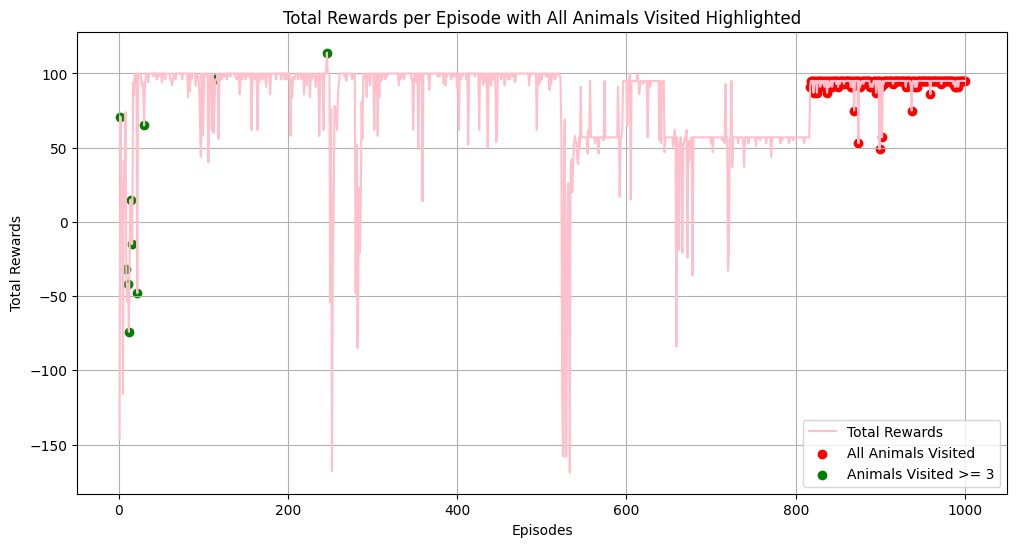

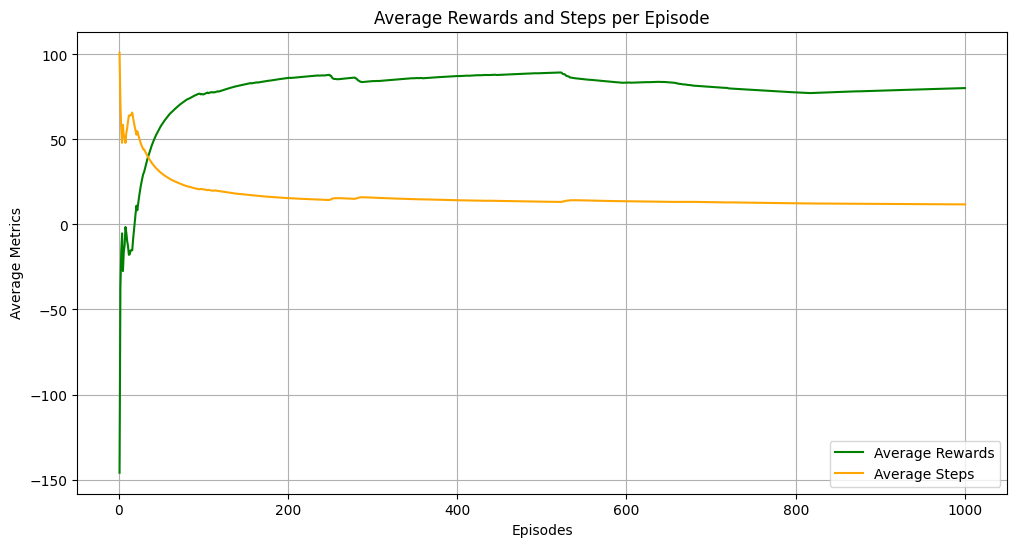

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

zoo_q_learning = Q_Learning(
    dims=(6, 6),
    rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 40, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
    start=(3, 0),
    end=(4, 5),
    positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
    tunnels={(0, 0): (1, 5), (1, 2): (4, 1)},
    epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.9999, 'epsilon_decay2': 0.999}
)
zoo_q_learning.max_episodes = 50000

# Best hyperparameters
alpha = 0.2
gamma = 0.9
epsilon = 0.1

# trying to avoid nan in updates
for key in zoo_q_learning._rewards.keys():
    zoo_q_learning._rewards[key] += 1e-5

# Run Q-learning with the best found hyperparameters
a_hist, Q_hist, Rtot, animals_visited_hist = zoo_q_learning.learn(alpha, gamma, epsilon)

#check for any NaN values in Q_hist and Rtot
print("Any NaNs in Q_hist?:", np.isnan(Q_hist).any())
print("Any NaNs in Rtot?:", np.isnan(Rtot).any())

#optimal path
path = find_path(Q_hist[-1])
r, steps = calculate_rewards(zoo_q_learning._R, path)
print("Path:", path)
print("Path in grid coords:", path_in_grids(path, zoo_q_learning._dims))
print("Total Rewards:", r)
print("Number of steps:", steps)

#number of unique animals visited on the optimal path
animal_positions = set((animal[0], animal[1]) for animal in zoo_q_learning._positions['animal'])
optimal_path_grid = path_in_grids(path, zoo_q_learning._dims)
animals_visited = len(animal_positions.intersection(optimal_path_grid))
print("Number of animals visited on Optimal Path:", animals_visited)

print(f"The best hyperparameters are: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

# total rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(Rtot, label='Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title(f'Total Reward per Episode with alpha={alpha}, gamma={gamma}, epsilon={epsilon}')
plt.legend()
plt.grid(True)
plt.show()

#the Q-matrix changes, average reward, and steps
plot_Q_changing(Q_hist, absolute=True)
average_R_display(Rtot)
steps_plot(a_hist)


episodes = np.arange(1, len(Rtot) + 1)  # No. of episodes
rewards = Rtot  #total rewards collected in each episode
steps = np.array([len(hist) for hist in a_hist])  # No. of steps in each episode
all_animals_visited = np.array([len(animal_positions.intersection(path_in_grids(find_path(Q_hist[i]), zoo_q_learning._dims))) == len(animal_positions) for i in range(len(Q_hist))])  #all animals were visited  or not in each episode

#check for episodes where the number of animals visited is >= 3
animals_visited_ge_3 = np.array(animals_visited_hist >= 3)

# Graph 1: All animals visited with exit and rewards collected
plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, label='Total Rewards', color='pink')
plt.scatter(episodes[all_animals_visited], rewards[all_animals_visited], color='red', label='All Animals Visited')
plt.scatter(episodes[animals_visited_ge_3], rewards[animals_visited_ge_3], color='green', label='Animals Visited >= 3')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Episode with All Animals Visited Highlighted')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graph 2: Average rewards collected each episode and steps
avg_rewards = np.cumsum(rewards) / episodes
avg_steps = np.cumsum(steps) / episodes

plt.figure(figsize=(12, 6))
plt.plot(episodes, avg_rewards, label='Average Rewards', color='green')
plt.plot(episodes, avg_steps, label='Average Steps', color='orange')
plt.xlabel('Episodes')
plt.ylabel('Average Metrics')
plt.title('Average Rewards and Steps per Episode')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
